In [11]:
import time

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
env = gym.make("CartPole-v1")

In [38]:
ACTION_SIZE = env.action_space.n
STATE_SIZE = env.observation_space.shape[0]

NUM_EPISODES = 1000
LEARNING_RATE = 0.001
DISCOUNT_FACTOR = 0.95
DECAY_RATE = 0.99

In [39]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.actor_fc1 = nn.Linear(128, 64)
        self.actor_fc2 = nn.Linear(64, action_size)
        self.critic_fc1 = nn.Linear(128, 64)
        self.critic_fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        actor_x = F.relu(self.actor_fc1(x))
        critic_x = F.relu(self.critic_fc1(x))
        return self.actor_fc2(actor_x), self.critic_fc2(critic_x)

In [89]:
def discount_rewards(rewards, discount_factor):
    discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
    last_reward = 0
    for i in reversed(range(len(rewards))):
        last_reward = rewards[i] + discount_factor * last_reward
        discounted_rewards[i] = last_reward

    return discounted_rewards

In [90]:
def calculate_gaes(rewards, values, discount_factor, decay_rate):
    next_values = np.append(values[1:], 0)
    deltas = rewards + discount_factor * next_values - values
    gaes = np.zeros_like(rewards, dtype=np.float32)
    last_gae = 0
    for i in reversed(range(len(deltas))):
        last_gae = deltas[i] + discount_factor * decay_rate * last_gae
        gaes[i] = last_gae

    gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
    return gaes

In [ ]:
def get_trajectory(env, actor_critic_model, max_steps):
    # states (no gradients needed), actions, rewards, values and log_probs (need to keep gradient info)
    states = []
    actions = []
    rewards = []
    values = []
    log_probs = []
    episode_reward = 0

    state, _ = env.reset()
    actor_critic_model.eval()
    for _ in range(max_steps):
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
        action_logits, value = actor_critic_model(state_tensor)
        action_distribution = Categorical(logits=action_logits)
        action = action_distribution.sample()
        next_state, reward, terminated, truncated, _ = env.step(action.item())

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        values.append(value)
        log_probs.append(action_distribution.log_prob(action))

        episode_reward += reward
        state = next_state
        if terminated or truncated:
            break

    states = np.array(states)
    rewards = np.array(rewards, dtype=np.float32)
    actions = torch.stack(actions)
    values = torch.cat(values).squeeze(-1)
    log_probs = torch.stack(log_probs)

    return (states, actions, rewards, values, log_probs), episode_reward


In [91]:
def train(model, optimizer, device, env, num_episodes, discount_factor, decay_rate):
    model.train()
    reward_history = []
    for episode_idx in range(num_episodes):
        (states, _, rewards, values, log_probs), episode_reward = get_trajectory(
            env, model, 200
        )
        reward_history.append(episode_reward)

        discounted_rewards = torch.tensor(
            discount_rewards(rewards, discount_factor), dtype=torch.float32
        ).to(device)

        values_np = values.detach().cpu().numpy()
        gaes_np = calculate_gaes(rewards, values_np, discount_factor, decay_rate)
        gaes = torch.tensor(gaes_np, dtype=torch.float32).to(device)

        permutation = torch.randperm(len(states)).to(device)
        values = values[permutation]
        log_probs = log_probs[permutation]
        discounted_rewards = discounted_rewards[permutation]
        gaes = gaes[permutation]

        actor_loss = -(log_probs * gaes).mean()
        critic_loss = F.mse_loss(values, discounted_rewards)
        total_loss = actor_loss + critic_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if episode_idx % 50 == 0:
            print(
                f"Episode {episode_idx}, Total Reward: {np.mean(reward_history[-50:])}, Loss: {total_loss.item()}"
            )

        if episode_idx % (num_episodes // 4) == 0 or episode_idx == num_episodes - 1:
            torch.save(model.state_dict(), f"actor_critic_{episode_idx}.pth")

    return reward_history

In [ ]:
model = ActorCriticNetwork(STATE_SIZE, ACTION_SIZE).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
env = gym.make("CartPole-v1")
rewards = train(
    model, optimizer, device, env, NUM_EPISODES, DISCOUNT_FACTOR, DECAY_RATE
)

/home/rabadaba/miniconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, Total Reward: 45.0, Loss: 181.22340393066406
Episode 50, Total Reward: 18.0, Loss: 25.56954002380371
Episode 100, Total Reward: 11.0, Loss: 7.323305606842041
Episode 150, Total Reward: 16.0, Loss: 3.511909008026123
Episode 200, Total Reward: 17.0, Loss: 33.691524505615234
Episode 250, Total Reward: 13.0, Loss: 20.787012100219727
Episode 300, Total Reward: 70.0, Loss: 38.03782653808594
Episode 350, Total Reward: 53.0, Loss: 18.33395004272461
Episode 400, Total Reward: 40.0, Loss: 52.492366790771484
Episode 450, Total Reward: 147.0, Loss: 5.864518165588379
Episode 500, Total Reward: 200.0, Loss: 13.417366027832031
Episode 550, Total Reward: 129.0, Loss: 18.72316551208496
Episode 600, Total Reward: 200.0, Loss: 14.894229888916016
Episode 650, Total Reward: 200.0, Loss: 11.569119453430176
Episode 700, Total Reward: 155.0, Loss: 7.699158191680908
Episode 750, Total Reward: 197.0, Loss: 13.261369705200195
Episode 800, Total Reward: 200.0, Loss: 9.584712028503418
Episode 850, Total

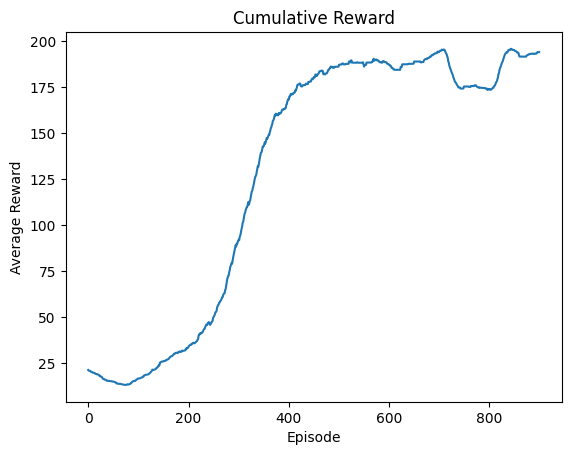

In [88]:
avg_rewards = [np.mean(rewards[i - 100 : i]) for i in range(100, len(rewards))]
plt.plot(avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Cumulative Reward")
plt.show()

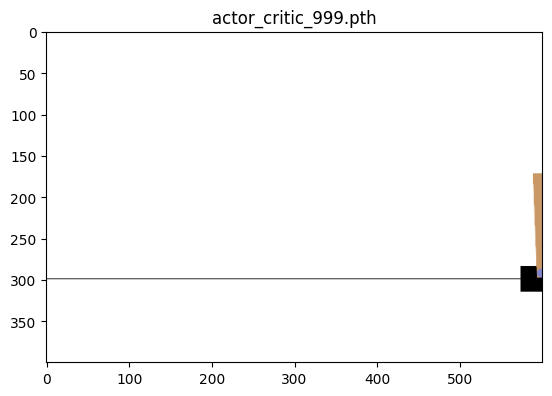

In [95]:
from pathlib import Path

import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline

for model_file in sorted(
    list(Path(".").glob("actor_critic_*.pth")), key=lambda x: int(x.stem.split("_")[2])
):
    print(model_file)
    model = ActorCriticNetwork(STATE_SIZE, ACTION_SIZE).to(device)
    model.load_state_dict(torch.load(model_file))
    model.eval()

    env = gym.make("CartPole-v1", render_mode="rgb_array")
    state, _ = env.reset()
    done = False
    img = plt.imshow(env.render())
    plt.title(model_file)
    while not done:
        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)

        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action = torch.argmax(model(state)[0]).item()
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        time.sleep(1 / 200)
    env.close()